In [7]:
import pandas as pd
import numpy as np
import wrds
import ffn
import pyfolio as pf
import matplotlib.pyplot as plt

In [8]:
conn = wrds.Connection(wrds_username='clu12')

Loading library list...
Done


In [4]:
# get IEF and IVV permno 
query = " \
SELECT * \
FROM crsp.dsenames \
WHERE ticker = 'IEF' \
OR ticker = 'IVV' \
"

ticker_history = conn.raw_sql(query)
ticker_history[['permno', 'namedt', 'ticker']]

,permno,namedt,ticker
0,88215.0,2000-05-19,IVV
1,88215.0,2002-01-02,IVV
2,88215.0,2004-06-10,IVV
3,88215.0,2005-11-30,IVV
4,88215.0,2006-07-07,IVV
5,88215.0,2006-10-19,IVV
6,88215.0,2007-12-06,IVV
7,88215.0,2012-10-01,IVV
8,88215.0,2016-02-02,IVV
9,88215.0,2017-12-26,IVV


In [3]:
# get IVV daily data
query = "\
SELECT *\
FROM crsp.dsf \
WHERE permno = 88215\
AND (date <= '2019-12-31' AND date >= '2002-07-31');"

IVV_daily_data = conn.raw_sql(query)
IVV_daily_ret = IVV_daily_data['ret']
IVV_daily_ret.index = IVV_daily_data['date']
IVV_daily_ret

date
2002-07-31    0.004509
2002-08-01   -0.030987
2002-08-02   -0.022147
2002-08-05   -0.032586
2002-08-06    0.029981
                ...   
2019-12-24    0.000124
2019-12-26    0.005176
2019-12-27   -0.000185
2019-12-30   -0.005397
2019-12-31    0.002263
Name: ret, Length: 4386, dtype: float64

In [4]:
# get IEF daily data
query = "\
SELECT *\
FROM crsp.dsf \
WHERE permno = 89469\
AND (date <= '2019-12-31' AND date >= '2002-07-31');"

IEF_daily_data = conn.raw_sql(query)
IEF_daily_ret = IEF_daily_data['ret']
IEF_daily_ret.index = IEF_daily_data['date']
IEF_daily_ret

date
2002-07-31    0.009172
2002-08-01    0.004120
2002-08-02    0.007724
2002-08-05    0.005030
2002-08-06   -0.008103
                ...   
2019-12-24    0.001724
2019-12-26    0.001450
2019-12-27    0.001448
2019-12-30   -0.000632
2019-12-31   -0.003616
Name: ret, Length: 4386, dtype: float64

In [5]:
IVV_IEF_ret_df = pd.DataFrame([IVV_daily_ret, IEF_daily_ret], index=['IVV', 'IEF']).T
IVV_IEF_ret_df

,IVV,IEF
date,,
2002-07-31,0.004509,0.009172
2002-08-01,-0.030987,0.004120
2002-08-02,-0.022147,0.007724
2002-08-05,-0.032586,0.005030
2002-08-06,0.029981,-0.008103
...,...,...
2019-12-24,0.000124,0.001724
2019-12-26,0.005176,0.001450
2019-12-27,-0.000185,0.001448


In [6]:
IVV_IEF_ret_df.to_csv('/Users/cheng/Google Drive/PhD/Research/Tactical asset allocation/data/IVV_IEF_daily_ret.csv')

In [5]:
# get IEF and IVV market data using permno
query = "\
SELECT *\
FROM crsp.dsf \
WHERE (permno = 88215 OR permno = 89469)\
AND (date <= '2019-12-31' AND date >= '2002-07-31');"

stock_daily_data = conn.raw_sql(query)
stock_daily_data.head()

,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,vol,ret,bid,ask,shrout,cfacpr,cfacshr,openprc,numtrd,retx
0,46428720,88215.0,37493.0,0.0,4.0,6726.0,2002-07-31,89.239998,91.449997,91.330002,3733800.0,0.004509,91.309998,91.459999,42500.0,1.0,1.0,90.459999,NaN,0.004509
1,46428720,88215.0,37493.0,0.0,4.0,6726.0,2002-08-01,88.449997,91.230003,88.500000,200300.0,-0.030987,88.419998,88.570000,42500.0,1.0,1.0,91.099998,NaN,-0.030987
2,46428720,88215.0,37493.0,0.0,4.0,6726.0,2002-08-02,85.720001,88.849998,86.540001,314600.0,-0.022147,86.400002,86.540001,42500.0,1.0,1.0,88.699997,NaN,-0.022147
3,46428720,88215.0,37493.0,0.0,4.0,6726.0,2002-08-05,83.599998,86.519997,83.720001,126100.0,-0.032586,83.540001,83.680000,42500.0,1.0,1.0,86.449997,NaN,-0.032586
4,46428720,88215.0,37493.0,0.0,4.0,6726.0,2002-08-06,85.550003,87.949997,86.230003,146600.0,0.029981,86.330002,86.470001,42500.0,1.0,1.0,85.570000,NaN,0.029981


In [21]:
set(stock_daily_data.permno)

{88215.0, 89469.0}

In [22]:
stock_daily_df = stock_daily_data[['permno', 'date', 'ret']].set_index('date')
stock_daily_df.index = pd.to_datetime(stock_daily_df.index)
stock_monthly_df = stock_daily_df.groupby([pd.Grouper(freq='M'), 'permno']).mean()

In [112]:
stock_daily_data[['permno', 'date', 'ret']].set_index(['permno', 'date'])

ret
permno  date                
88215.0 2002-07-31  0.004509
        2002-08-01 -0.030987
        2002-08-02 -0.022147
        2002-08-05 -0.032586
        2002-08-06  0.029981
...                      ...
89469.0 2019-12-24  0.001724
        2019-12-26  0.001450
        2019-12-27  0.001448
        2019-12-30 -0.000632
        2019-12-31 -0.003616

[8772 rows x 1 columns]

In [111]:
stock_daily_df = stock_daily_data[['permno', 'date', 'ret']].set_index('date')
stock_daily_df.index = pd.to_datetime(stock_daily_df.index)
stock_daily_df.groupby(['permno',pd.Grouper(freq='M')]).sum()

ret
permno  date                
88215.0 2002-07-31  0.004509
        2002-08-31  0.009394
        2002-09-30 -0.106182
        2002-10-31  0.086342
        2002-11-30  0.058013
...                      ...
89469.0 2019-08-31  0.038970
        2019-09-30 -0.011738
        2019-10-31  0.002019
        2019-11-30 -0.006790
        2019-12-31 -0.009170

[420 rows x 1 columns]

In [23]:
stock_monthly_df = stock_monthly_df.unstack(level='permno')
stock_monthly_df.columns = [88215, 89469]
stock_monthly_df

,88215,89469
date,,
2002-07-31,0.004509,0.009172
2002-08-31,0.000427,0.001145
2002-09-30,-0.005309,0.001902
2002-10-31,0.003754,-0.000530
2002-11-30,0.002901,-0.001039
...,...,...
2019-08-31,-0.000659,0.001771
2019-09-30,0.000981,-0.000587
2019-10-31,0.000962,0.000088


In [24]:
# load market capital weight
w_mktcap_df = pd.read_csv('/Users/cheng/Google Drive/PhD/Research/Tactical asset allocation/data/mktcap_w_ief_ivv.csv',
                          index_col=0,
                          parse_dates=True)

In [25]:
# convert daily data to monthly data
w_mktcap_month = w_mktcap_df.groupby(pd.Grouper(freq='M')).mean()

In [27]:
# rename column name for element wise product 
w_mktcap_month.columns = ['IEF', 'IVV']
stock_monthly_df.columns = ['IVV', 'IEF']
stock_monthly_df = stock_monthly_df[['IEF', 'IVV']]

In [28]:
w_mktcap_month = w_mktcap_month[:-1] # remove the last weight
stock_monthly_df = stock_monthly_df[1:] # remove the first month

In [48]:
# backtest strategy to get portfolio return
portfolio_ret_mktcap = np.sum(stock_monthly_df.values * w_mktcap_month.values, axis=1)
portfolio_ret_fixed = stock_monthly_df @ pd.DataFrame([0.4, 0.6], index=['IEF', 'IVV'])
portfolio_ret_mktcap = pd.DataFrame(portfolio_ret_mktcap, index=stock_monthly_df.index, columns=['portfolio_ret_mktcap'])
portfolio_ret_mktcap.head()

,portfolio_ret_mktcap
date,
2002-08-31,0.000541
2002-09-30,-0.004208
2002-10-31,0.002972
2002-11-30,0.002193
2002-12-31,-0.001899


In [135]:
portfolio_ret_df = pd.concat([portfolio_ret_mktcap, portfolio_ret_fixed], axis=1)
portfolio_ret_df.columns = ['portfolio_ret_mktcap', 'portfolio_ret_fixed']

In [156]:
portfolio_ret_df.std() * 12

portfolio_ret_mktcap    0.019356
portfolio_ret_fixed     0.012709
dtype: float64

In [142]:
portfolio_ret_df.mean() * 12

portfolio_ret_mktcap    0.004944
portfolio_ret_fixed     0.004026
dtype: float64

In [138]:
np.sqrt(12) * portfolio_ret_df.mean() / portfolio_ret_df.std()

portfolio_ret_mktcap    0.884865
portfolio_ret_fixed     1.097457
dtype: float64

In [145]:
ret_cum_df = ((1 + portfolio_ret_df).cumprod() - 1)

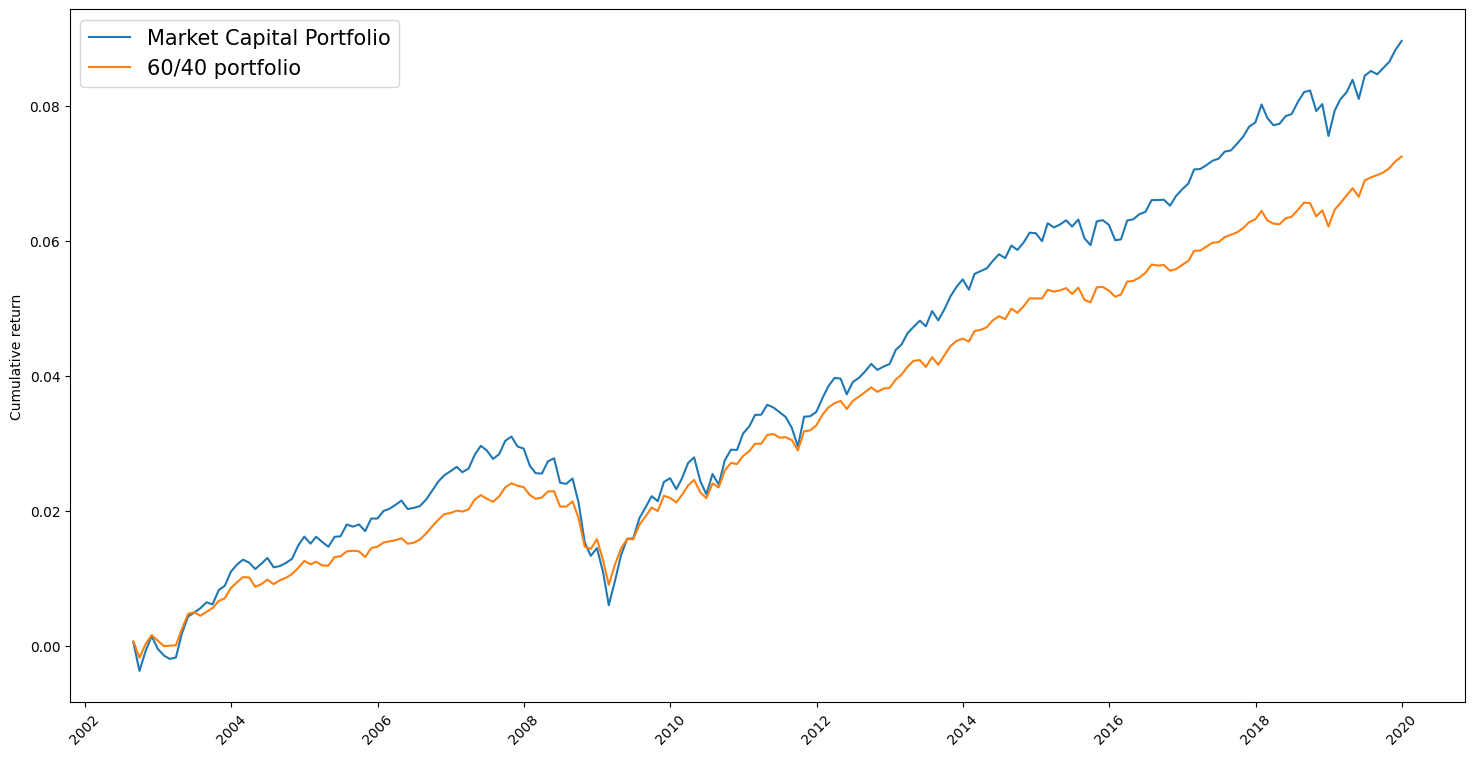

In [155]:
fig = plt.figure(figsize=(18,9))
plt.plot(ret_cum_df)
plt.ylabel('Cumulative return')
plt.tick_params(axis='x', rotation=45)
plt.legend(['Market Capital Portfolio', '60/40 portfolio'], prop={'size': 15})